In [ ]:
import os
import librosa
import numpy as np
import soundfile as sf
import joblib
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# ✅ Google Drive paths
gdrive_root = "/content/drive/MyDrive/EmotionRecognitionAssets"
os.makedirs(gdrive_root, exist_ok=True)


speech_path = "/content/drive/MyDrive/SPEECH"
song_path = "/content/drive/MyDrive/SONGS"

# --------------------------------------------
# EMOTION MAP
# --------------------------------------------
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def parse_emotion(filename):
    parts = filename.split("-")
    return emotion_map.get(parts[2])

# --------------------------------------------
# FEATURE EXTRACTION
# --------------------------------------------
def extract_features(file_path, max_len=173):
    X, sr = librosa.load(file_path, sr=22050)
    mfcc = librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    chroma = librosa.feature.chroma_stft(y=X, sr=sr)
    mel = librosa.feature.melspectrogram(y=X, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=X, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sr)
    rmse = librosa.feature.rms(y=X)
    zcr = librosa.feature.zero_crossing_rate(y=X)

    features = np.vstack([mfcc, delta, delta2, chroma, mel, contrast, tonnetz, rmse, zcr])

    if features.shape[1] < max_len:
        pad_width = max_len - features.shape[1]
        features = np.pad(features, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        features = features[:, :max_len]

    return features.T

# --------------------------------------------
# AUGMENTATION
def augment_audio(X, sr):
    aug_methods = [
        lambda x, sr: librosa.effects.pitch_shift(x, sr=sr, n_steps=random.uniform(-2, 2)),
        lambda x, sr: librosa.effects.time_stretch(x, rate=random.uniform(0.85, 1.15)),
        lambda x, sr: x + 0.005 * np.random.normal(0, 1, len(x)),
        lambda x, sr: x * random.uniform(0.8, 1.2)
    ]
    method = random.choice(aug_methods)
    return method(X, sr)


# --------------------------------------------
# LOAD DATASET WITH OPTIONAL AUGMENTATION
# --------------------------------------------
def load_dataset(folder_path, file_list, augment=False):
    X, y = [], []
    for file in file_list:
        label = parse_emotion(file)
        if label is None: continue
        full_path = os.path.join(folder_path, file)

        # Original
        features = extract_features(full_path)
        X.append(features)
        y.append(label)

        # Augmented
        if augment:
            audio, sr = librosa.load(full_path, sr=22050)
            aug_audio = augment_audio(audio, sr)
            sf.write("temp_aug.wav", aug_audio, sr)
            features_aug = extract_features("temp_aug.wav")
            X.append(features_aug)
            y.append(label)
            os.remove("temp_aug.wav")
    return np.array(X), np.array(y)

# --------------------------------------------
# SPLIT FILES WITH STRATIFICATION
# --------------------------------------------
def split_files(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]
    labels = [parse_emotion(f) for f in files]
    return train_test_split(files, test_size=0.2, stratify=labels, random_state=42)

# --------------------------------------------
# FINAL PHASE 1 RUN
# --------------------------------------------
print("Splitting speech and song datasets...")
speech_train, speech_val = split_files(speech_path)
song_train, song_val = split_files(song_path)

print("Extracting training features with augmentation...")
X_train_speech, y_train_speech = load_dataset(speech_path, speech_train, augment=True)
X_train_song, y_train_song = load_dataset(song_path, song_train, augment=True)

print("Extracting validation features...")
X_val_speech, y_val_speech = load_dataset(speech_path, speech_val, augment=False)
X_val_song, y_val_song = load_dataset(song_path, song_val, augment=False)

# Combine datasets
X_train = np.concatenate([X_train_speech, X_train_song], axis=0)
y_train = np.concatenate([y_train_speech, y_train_song], axis=0)
X_val = np.concatenate([X_val_speech, X_val_song], axis=0)
y_val = np.concatenate([y_val_speech, y_val_song], axis=0)

# Label encode + one-hot
le = LabelEncoder()
y_train_encoded = to_categorical(le.fit_transform(y_train))
y_val_encoded = to_categorical(le.transform(y_val))

# Save label encoder
joblib.dump(le, os.path.join(gdrive_root, "label_encoder.pkl"))

# Scale features
print("Scaling features and saving scaler...")
scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, X_train.shape[-1])
X_val_flat = X_val.reshape(-1, X_val.shape[-1])

scaler.fit(X_train_flat)
X_train_scaled = scaler.transform(X_train_flat).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val_flat).reshape(X_val.shape)

# Save scaler to Google Drive
joblib.dump(scaler, os.path.join(gdrive_root, "scaler.pkl"))

print(" PHASE 1 COMPLETE")
print(f" X_train shape: {X_train_scaled.shape}, y_train: {y_train_encoded.shape}")
print(f" X_val shape: {X_val_scaled.shape}, y_val: {y_val_encoded.shape}")
print(f" Scaler + label encoder saved to: {gdrive_root}")


Splitting speech and song datasets...
Extracting training features with augmentation...
Extracting validation features...
Scaling features and saving scaler...
✅ PHASE 1 COMPLETE
📊 X_train shape: (3844, 173, 275), y_train: (3844, 8)
📊 X_val shape: (482, 173, 275), y_val: (482, 8)
💾 Scaler + label encoder saved to: /content/drive/MyDrive/EmotionRecognitionAssets


In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, Dropout, BatchNormalization,
                                     Bidirectional, LSTM, Dense, Flatten)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ------------------------------
# 🧠 Define Model Architecture
# ------------------------------
def build_cnn_bilstm_model(input_shape, num_classes):
    model = Sequential()

    # CNN layers
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    # BiLSTM layers
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.3))

    # MLP
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# ------------------------------
# ✅ Prepare Inputs
# ------------------------------
input_shape = X_train_scaled.shape[1:]   # (173, ~110)
num_classes = y_train_encoded.shape[1]   # usually 8 for RAVDESS

# ------------------------------
# 🚀 Build & Compile Model
# ------------------------------
model = build_cnn_bilstm_model(input_shape, num_classes)

optimizer = Adam(learning_rate=1e-3, clipnorm=1.0)  # Gradient clipping
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 171, 64)        │        52,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 171, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 85, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 85, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 83, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 83, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 41, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 39, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 39, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 19, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 19, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 19, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 19, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 573,192 (2.19 MB)

 Trainable params: 572,552 (2.18 MB)

 Non-trainable params: 640 (2.50 KB)

In [27]:
# Save model to Google Drive
checkpoint_path = "/content/drive/MyDrive/EmotionRecognitionAssets/best_model.h5"

callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
]


In [29]:
history = model.fit(
    X_train_scaled, y_train_encoded,
    validation_data=(X_val_scaled, y_val_encoded),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9679 - loss: 0.5738
Epoch 1: val_accuracy did not improve from 0.83610
121/121 ━━━━━━━━━━━━━━━━━━━━ 35s 291ms/step - accuracy: 0.9679 - loss: 0.5738 - val_accuracy: 0.8174 - val_loss: 0.8947 - learning_rate: 6.2500e-05
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9736 - loss: 0.5607
Epoch 2: val_accuracy did not improve from 0.83610
121/121 ━━━━━━━━━━━━━━━━━━━━ 34s 236ms/step - accuracy: 0.9736 - loss: 0.5607 - val_accuracy: 0.8237 - val_loss: 0.8909 - learning_rate: 6.2500e-05
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9746 - loss: 0.5613
Epoch 3: val_accuracy did not improve from 0.83610
121/121 ━━━━━━━━━━━━━━━━━━━━ 31s 253ms/step - accuracy: 0.9746 - loss: 0.5613 - val_accuracy: 0.8154 - val_loss: 0.9011 - learning_rate: 6.2500e-05
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9775 - loss: 0.5556
Epoch 4: val_accuracy did not improve from 0.83610


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step
✅ Overall Accuracy: 83.61%
✅ Macro F1 Score: 83.73%
📋 Classification Report:
               precision    recall  f1-score   support

       angry     0.9853    0.8933    0.9371        75
        calm     0.8684    0.8919    0.8800        74
     disgust     0.9143    0.8649    0.8889        37
     fearful     0.7326    0.8514    0.7875        74
       happy     0.8472    0.8243    0.8356        74
     neutral     0.6977    0.8108    0.7500        37
         sad     0.7794    0.7162    0.7465        74
   surprised     0.9118    0.8378    0.8732        37

    accuracy                         0.8361       482
   macro avg     0.8421    0.8363    0.8373       482
weighted avg     0.8426    0.8361    0.8375       482



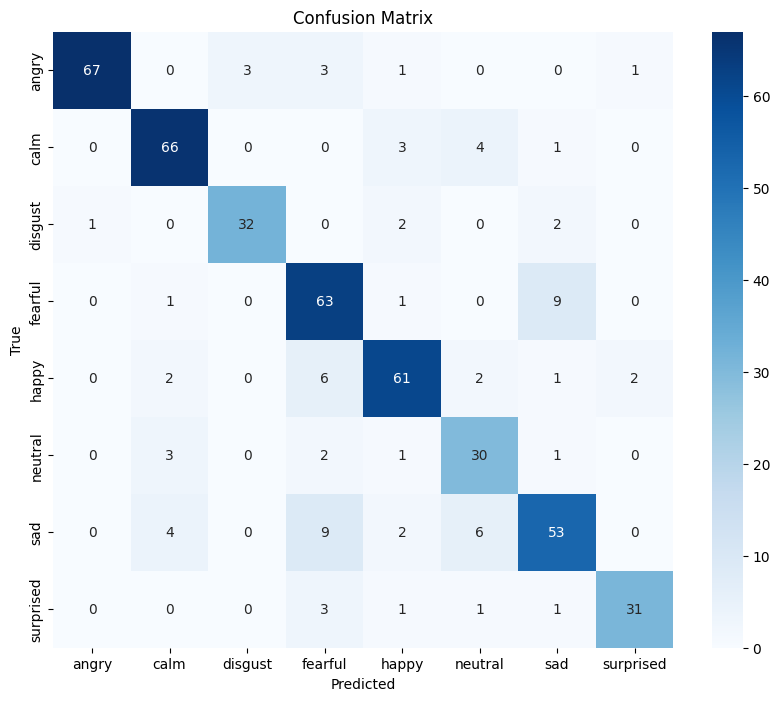

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# ------------------------------
# 📥 Load Model & LabelEncoder
# ------------------------------
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/EmotionRecognitionAssets/best_model.h5")
label_encoder = joblib.load("/content/drive/MyDrive/EmotionRecognitionAssets/label_encoder.pkl")

# ------------------------------
# 🔮 Predict on Validation Set
# ------------------------------
y_pred_probs = model.predict(X_val_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val_encoded, axis=1)

# ------------------------------
# ✅ Accuracy & F1 Score
# ------------------------------
overall_accuracy = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average='macro')

print(f" Overall Accuracy: {overall_accuracy * 100:.2f}%")
print(f" Macro F1 Score: {macro_f1 * 100:.2f}%")

# ------------------------------
# 📊 Class-wise Accuracy
# ------------------------------
class_report = classification_report(
    y_true, y_pred,
    target_names=label_encoder.classes_,
    digits=4,
    zero_division=0
)
print("📋 Classification Report:\n", class_report)

# ------------------------------
# 📉 Confusion Matrix
# ------------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Get label names
class_names = label_encoder.classes_

# Initialize storage
class_accuracies = {}

# Loop through each class
for i, class_name in enumerate(class_names):
    # Get indices of samples for that class
    idx = np.where(y_true == i)[0]

    # Get corresponding predictions
    correct = np.sum(y_pred[idx] == y_true[idx])
    total = len(idx)

    accuracy = correct / total if total > 0 else 0
    class_accuracies[class_name] = accuracy * 100

# Print nicely
print(" Class-wise Accuracy:")
for label, acc in class_accuracies.items():
    print(f"{label:10s} : {acc:.2f}%")


🎯 Class-wise Accuracy:
angry      : 89.33%
calm       : 89.19%
disgust    : 86.49%
fearful    : 85.14%
happy      : 82.43%
neutral    : 81.08%
sad        : 71.62%
surprised  : 83.78%
